# ***MNIST_baseline***

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
workspace_path = '/gdrive/My Drive/Colab Notebooks'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784, 256) # MNIST img: 784차원을 256차원으로축소
    self.fc2 = nn.Linear(256, 32) # 256차원을 32차원으로 축소
    self.fc3 = nn.Linear(32, 10) # 출력값은 몇개가 나와야 하는지 설정을 해준다.(손글씨 숫자 10종 판별)

  
  def forward(self, x):
    x = x.float()
    h1 = F.relu(self.fc1(x.view(-1, 784)))
    h2 = F.relu(self.fc2(h1))
    h3 = self.fc3(h2)
    return h3
  
  print('init model done')

init model done


In [ ]:
# 하이퍼파라미터로 학습을 하기 위한 학습세팅 값
batch_size = 64 # 학습 배치 크기
test_batch_size = 1000 # 학습 과정을 제외하므로 크게 잡는다.
max_epochs = 10 # 총 훈련 할 횟수
lr = 0.01 # 학습률 (), learning rate 줄인 약자.
momentum = 0.5 # SGD에 사용할 모멘텀, 관성값, 학습할 방향성에 관성
seed = 1 # 결과 재현을 위한 시드값
log_interval = 200 # 200번 로그를 남김

use_cuda = torch.cuda.is_available()  # GPU cuda 사용 여부확인

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers':1, 'pin_memory':True} if use_cuda else {} # num_workers:data loading할 프로세스 수, pin_memory:고정된 메모리 영역

print("set vars and device done")

set vars and device done


In [ ]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.5,), (0.5,))])  # 임의의 값으로 초기화 (일반적으로는 학습 데이터셋의 평균, 표준편차 사용)

# 학습용 데이터 로더 (MNIST 학습 데이터셋 사용)
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST(os.path.join(workspace_path, 'data'), train=True, download=True, transform=transform),batch_size = batch_size, shuffle=True, drop_last=True, **kwargs)

# 테스트용 데이터 로더 (MNIST 테스트 데이터셋 사용)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.join(workspace_path, 'data'), train=False, download=True, transform=transform), batch_size=test_batch_size, shuffle=True, **kwargs)

<Figure size 432x288 with 0 Axes>

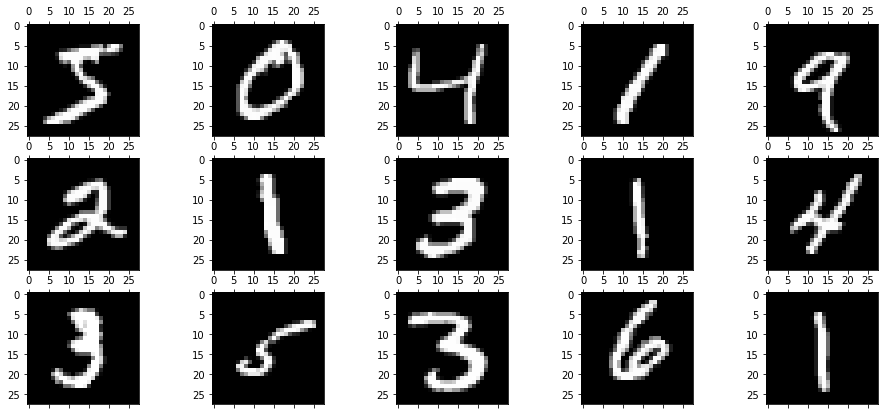

In [ ]:
plt.gray()
fig = plt.figure(figsize=(16,7))
for i in range(0,15):
  data, _ = train_loader.dataset[i]
  data = data.numpy()
  ax = fig.add_subplot(3,5,i+1, title = "")
  ax.matshow(data.reshape((28,28)).astype(float))
plt.show()

In [ ]:
model = Net().to(device) # 모델정의
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss() # 손실 함수 정의 , 카테고리 형태의 문제를 풀 때 사용

In [ ]:
class AverageMeter(object):
  """computes and stores the average and current value"""
  def __init__(self):
    self.reset()
  
  def reset(self):
    self.val=0
    self.avg=0
    self.sum=0
    self.count=0

  def update(self, val, n=1):
    self.val=val
    self.sum += val*n
    self.count += n
    self.avg = self.sum/self.count

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):# train함수 정의
    model.train()  # 모델 학습 모드 설정
    summary_loss = AverageMeter()  # 학습 손실값 기록 초기화
    summary_acc = AverageMeter() # 학습 정확도 기록 초기화
    for batch_idx, (data, target) in enumerate(train_loader): # train loader 하나 들어오면 순회
        data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
        optimizer.zero_grad()  # gradient 0으로 초기화
        output = model(data)  # 모델에 입력값 feed-forward
        loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답(target)간의 손실값 계산
        loss.backward()  # 손실값 역전파 (각 계층에서 gradient 계산, pytorch는 autograd로 gradient 자동 계산)
        optimizer.step()  # 모델의 파라미터 업데이트 (gradient 이용하여 파라미터 업데이트)
        summary_loss.update(loss.detach().item())  # 손실값 기록
        pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
        correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
        summary_acc.update(correct / data.size(0))  # 정확도 기록
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()  # 모델 검증 모드 설정 (inference mode)
    summary_loss = AverageMeter()  # 테스트 손실값 기록 초기화
    summary_acc = AverageMeter() # 테스트 정확도 기록 초기화
    with torch.no_grad():  # 검증 모드이므로 gradient 계산안함
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
            output = model(data)  # 모델에 입력값 feed-forward
            loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
            summary_loss.update(loss.detach().item())  # 손실값 기록
            pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
            correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
            summary_acc.update(correct / data.size(0))  # 정확도 기록

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg))  # 정답을 맞춘 개수 / 테스트셋 샘플 수 -> Accuracy

    return summary_loss.avg, summary_acc.avg

In [ ]:
for epoch in range(1, max_epochs+1):
    best_acc = 0
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    # 테스트에서 best accuracy 달성하면 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model, os.path.join(workspace_path, f'mnist_ann_model_best_acc_{epoch}-epoch.pt'))
        print(f'# save model: mnist_ann_model_best_acc_{epoch}-epoch.pt\n')

Train Epoch: 1 [0/60000 (0%)]	Average loss: 2.312202, Accuracy: 0.062500
Train Epoch: 1 [12800/60000 (21%)]	Average loss: 1.707849, Accuracy: 0.499378
Train Epoch: 1 [25600/60000 (43%)]	Average loss: 1.171320, Accuracy: 0.666108
Train Epoch: 1 [38400/60000 (64%)]	Average loss: 0.926037, Accuracy: 0.736169
Train Epoch: 1 [51200/60000 (85%)]	Average loss: 0.792211, Accuracy: 0.773974

Test set: Average loss: 0.3321, Accuracy: 0.905400

# save model: mnist_ann_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/60000 (0%)]	Average loss: 0.290889, Accuracy: 0.906250
Train Epoch: 2 [12800/60000 (21%)]	Average loss: 0.344243, Accuracy: 0.900187
Train Epoch: 2 [25600/60000 (43%)]	Average loss: 0.339589, Accuracy: 0.901301
Train Epoch: 2 [38400/60000 (64%)]	Average loss: 0.329704, Accuracy: 0.904248
Train Epoch: 2 [51200/60000 (85%)]	Average loss: 0.323233, Accuracy: 0.905567

Test set: Average loss: 0.2767, Accuracy: 0.918800

# save model: mnist_ann_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/6000

# ***CIFAR10_baseline***

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32*32*3, 256)
    self.fc2 = nn.Linear(256, 32)
    self.fc3 = nn.Linear(32,10)

  def forward(self, x):
    x = x.float()
    h1 = F.relu(self.fc1(x.view(-1,32*32*3)))
    h2 = F.relu(self.fc2(h1))
    h3 = self.fc3(h2)
    return h3

print("init model done")

init model done


In [ ]:
batch_size = 64
test_batch_size = 1000
max_epochs = 10
lr = 0.01
momentum = 0.5
seed = 1
log_interval = 200
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers':1, 'pin_memory':True} if use_cuda else {}
print("set vars and device done")

set vars and device done


In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),transforms.Normalize(
                                    (0.5,0.5,0.5), (0.5,0.5,0.5)
                                )
])
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(os.path.join(workspace_path, 'data'), train=True, download=True, transform=transform),
                                           batch_size=batch_size, shuffle=True, drop_last = True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join(workspace_path, 'data'), train=False, download=True, transform=transform),
    batch_size=test_batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [ ]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()
  
  def reset(self):
    self.val=0
    self.avg=0
    self.sum=0
    self.count=0
  
  def update(self, val, n=1):
    self.val = val
    self.sum += val*n
    self.count +=n
    self.avg = self.sum/self.count

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()  # 모델 학습 모드 설정
    summary_loss = AverageMeter()  # 학습 손실값 기록 초기화
    summary_acc = AverageMeter() # 학습 정확도 기록 초기화
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
        optimizer.zero_grad()  # gradient 0으로 초기화
        output = model(data)  # 모델에 입력값 feed-forward
        loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
        loss.backward()  # 손실값 역전파 (각 계층에서 gradient 계산, pytorch는 autograd로 gradient 자동 계산)
        optimizer.step()  # 모델의 파라미터 업데이트 (gradient 이용하여 파라미터 업데이트)
        summary_loss.update(loss.detach().item())  # 손실값 기록
        pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
        correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
        summary_acc.update(correct / data.size(0))  # 정확도 기록
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()  # 모델 검증 모드 설정 (inference mode)
    summary_loss = AverageMeter()  # 테스트 손실값 기록 초기화
    summary_acc = AverageMeter() # 테스트 정확도 기록 초기화
    with torch.no_grad():  # 검증 모드이므로 gradient 계산안함
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
            output = model(data)  # 모델에 입력값 feed-forward
            loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
            summary_loss.update(loss.detach().item())  # 손실값 기록
            pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
            correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
            summary_acc.update(correct / data.size(0))  # 정확도 기록

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg))  # 정답을 맞춘 개수 / 테스트셋 샘플 수 -> Accuracy

    return summary_loss.avg, summary_acc.avg

In [ ]:
for epoch in range(1, max_epochs+1):
    best_acc = 0
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    # 테스트에서 best accuracy 달성하면 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model, os.path.join(workspace_path, f'cifar10_ann_model_best_acc_{epoch}-epoch.pt'))
        print(f'# save model: cifar10_ann_model_best_acc_{epoch}-epoch.pt\n')

Train Epoch: 1 [0/50000 (0%)]	Average loss: 2.304628, Accuracy: 0.109375
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 2.194363, Accuracy: 0.203980
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 2.067708, Accuracy: 0.257364
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 1.987291, Accuracy: 0.292377

Test set: Average loss: 1.7214, Accuracy: 0.393900

# save model: cifar10_ann_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/50000 (0%)]	Average loss: 1.644846, Accuracy: 0.437500
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 1.695115, Accuracy: 0.404307
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 1.674992, Accuracy: 0.406640
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 1.654580, Accuracy: 0.415245

Test set: Average loss: 1.5737, Accuracy: 0.447600

# save model: cifar10_ann_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/50000 (0%)]	Average loss: 1.641424, Accuracy: 0.437500
Train Epoch: 3 [12800/50000 (26%)]	Average loss: 1.544297, Accuracy: 0.454136
Train Epoch: 3 [25600/5

# ***CIFAR-100***

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32*32*3,256)
    self.fc2 = nn.Linear(256,32)
    self.fc3 = nn.Linear(32,100)

  def forward(self, x):
    x = x.float()
    h1 = F.relu(self.fc1(x.view(-1, 32*32*3)))
    h2 = F.relu(self.fc2(h1))
    h3 = self.fc3(h2)
    return h3

print("init model done")

init model done


In [ ]:
batch_size = 64
test_batch_size = 1000
max_epochs = 10  
lr = 0.01  
momentum = 0.5 
seed = 1  
log_interval = 200

use_cuda = torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

print("set vars and device done")

set vars and device done


In [ ]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(
  datasets.CIFAR100(os.path.join(workspace_path, 'data'), train=True, download=True, 
                   transform=transform), 
    batch_size = batch_size, shuffle=True, drop_last=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(os.path.join(workspace_path, 'data'), train=False, download=True,
                         transform=transform), 
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = Net().to(device)  
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  
criterion = nn.CrossEntropyLoss()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train() 
    summary_loss = AverageMeter() 
    summary_acc = AverageMeter() 
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = criterion(output, target) 
        loss.backward() 
        optimizer.step()  
        summary_loss.update(loss.detach().item()) 
        pred = output.argmax(dim=1, keepdim=True)  
        correct = pred.eq(target.view_as(pred)).sum().item() 
        summary_acc.update(correct / data.size(0)) 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()  
    summary_loss = AverageMeter()  
    summary_acc = AverageMeter() 
    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)  
            loss = criterion(output, target) 
            summary_loss.update(loss.detach().item()) 
            pred = output.argmax(dim=1, keepdim=True) 
            correct = pred.eq(target.view_as(pred)).sum().item() 
            summary_acc.update(correct / data.size(0)) 

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg)) 

    return summary_loss.avg, summary_acc.avg

In [ ]:
for epoch in range(1, max_epochs+1):
    best_acc = 0
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model, os.path.join(workspace_path, f'cifar100_ann_model_best_acc_{epoch}-epoch.pt'))
        print(f'# save model: cifar100_ann_model_best_acc_{epoch}-epoch.pt\n')

Train Epoch: 1 [0/50000 (0%)]	Average loss: 4.622047, Accuracy: 0.000000
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 4.570876, Accuracy: 0.028685
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 4.508444, Accuracy: 0.035887
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 4.419415, Accuracy: 0.044275

Test set: Average loss: 4.0372, Accuracy: 0.087600

# save model: cifar100_ann_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/50000 (0%)]	Average loss: 4.006414, Accuracy: 0.109375
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 3.980313, Accuracy: 0.095149
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 3.941499, Accuracy: 0.101777
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 3.901882, Accuracy: 0.108595

Test set: Average loss: 3.7489, Accuracy: 0.139200

# save model: cifar100_ann_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/50000 (0%)]	Average loss: 3.762461, Accuracy: 0.093750
Train Epoch: 3 [12800/50000 (26%)]	Average loss: 3.705311, Accuracy: 0.140392
Train Epoch: 3 [25600

**Batch_size 64일경우**
Test set: Average loss: 3.3468, Accuracy: 0.208400

**Batch_size 128일경우**
Test set: Average loss: 3.5459, Accuracy: 0.171700

**Batch_size 32일경우**
Test set: Average loss: 3.2338, Accuracy: 0.231200

**self.fc1 = nn.Linear(32*32*3,512) ,self.fc2 = nn.Linear(512,256),self.fc3 = nn.Linear(256,100) 일 경우**
Test set: Average loss: 3.2310, Accuracy: 0.237100
